## Look at Refitted model performances
---

In [1]:
import json, sys, os

sys.path.insert(1, "../..")
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns
import smart_open
import shap

from src.utils import deposit_v1_scale_score, build_score_coefficients, scale_ach_v2_dev, scale_ach_v2_refit

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [2]:
# modeling_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_modeling_df_refit.parquet')
test_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_test_df_refit.parquet')

<AxesSubplot:>

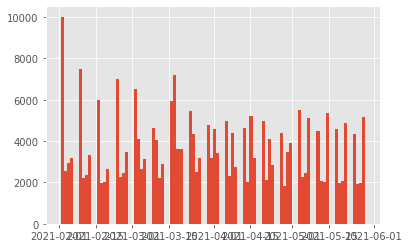

In [3]:
test_df.transaction_datetime.hist(bins=100)

In [4]:
test_df["deposit_v1_score"] = deposit_v1_scale_score(test_df["deposit_v1_pred"])

test_df["deposit_v2_ach_refit_pred"] = test_df["score"] / 100
test_df["ach_v2_score_refit"] = scale_ach_v2_refit(test_df["deposit_v2_ach_refit_pred"])

test_df["deposit_v2_ach_dev_final_pred"]
test_df["ach_v2_score_dev"] = scale_ach_v2_dev(test_df["deposit_v2_ach_dev_final_pred"])

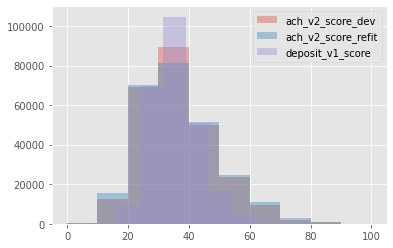

In [5]:
test_df["ach_v2_score_dev"].hist(bins=10, alpha=0.4, legend="ach_v2_dev")
test_df["ach_v2_score_refit"].hist(bins=10, alpha=0.4, legend="ach_v2_refit")
test_df["deposit_v1_score"].hist(bins=10, alpha=0.4, legend="deposit_v1")
plt.show()

In [6]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [7]:
test_df.columns[test_df.columns.str.contains("pred")]

Index(['deposit_v1_pred', 'customer_pred', 'deposit_v2_ach_dev_final_pred',
       'customer_refit_2021Q1_pred', 'pred', 'deposit_v2_ach_refit_pred'],
      dtype='object')

In [8]:
target_col = "is_returned"
pred_cols_all = ['deposit_v1_pred', 'customer_pred', 
             'deposit_v2_ach_dev_final_pred', 'customer_refit_2021Q1_pred',
             'deposit_v2_ach_refit_pred']
pred_cols = ['deposit_v1_pred', 'customer_refit_2021Q1_pred', 
             'deposit_v2_ach_refit_pred']
print(target_col)
metrics = get_pred_reports(test_df, target_col, pred_cols_all).sort_values(by=["ap", "auc"])
print(metrics.to_csv())
metrics

is_returned
,auc,ap,ks
deposit_v1_pred,81.22,22.31,48.82
customer_pred,84.7,29.68,54.95
customer_refit_2021Q1_pred,86.99,38.15,59.82
deposit_v2_ach_dev_final_pred,88.72,43.09,62.68
deposit_v2_ach_refit_pred,89.28,44.22,64.25



,auc,ap,ks
deposit_v1_pred,81.22,22.31,48.82
customer_pred,84.70,29.68,54.95
customer_refit_2021Q1_pred,86.99,38.15,59.82
deposit_v2_ach_dev_final_pred,88.72,43.09,62.68
deposit_v2_ach_refit_pred,89.28,44.22,64.25


(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

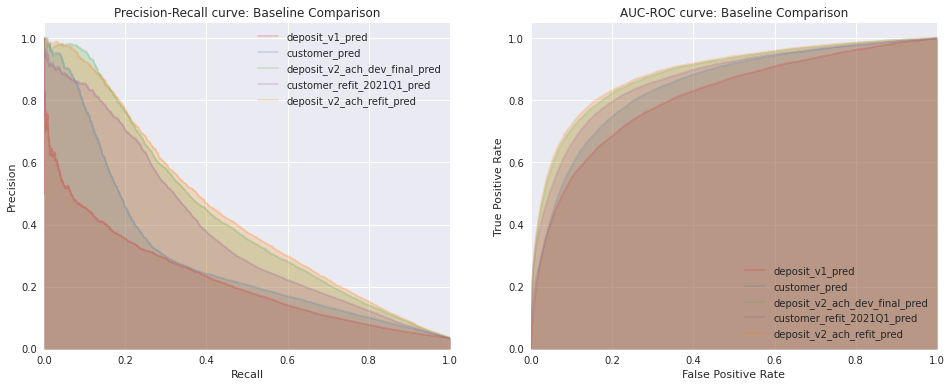

In [9]:
preds = [(test_df[col], col) for col in pred_cols_all]

fig, axs = plt.subplots(1, 2, figsize=(16,6))
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[1], fig=fig)

(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

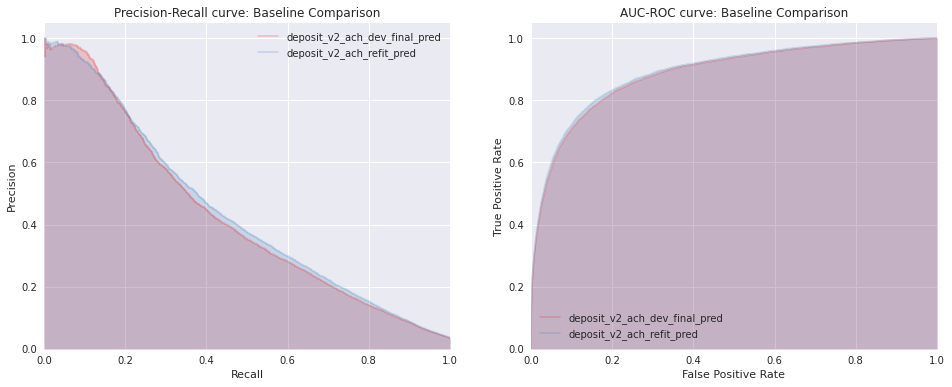

In [10]:
pred_cols_ = ['deposit_v2_ach_dev_final_pred', 
              'deposit_v2_ach_refit_pred']
preds = [(test_df[col], col) for col in pred_cols_]

fig, axs = plt.subplots(1, 2, figsize=(16,6))
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[1], fig=fig)

(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

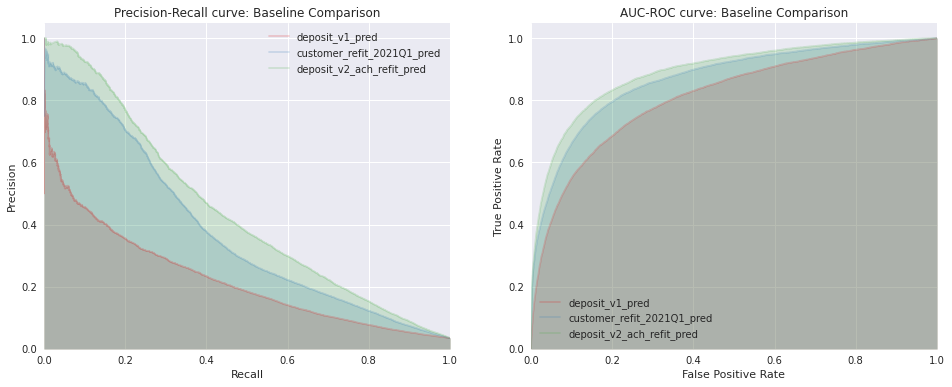

In [11]:
preds = [(test_df[col], col) for col in pred_cols]

fig, axs = plt.subplots(1, 2, figsize=(16,6))
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[1], fig=fig)

========= month: 2 =========


,auc,ap,ks
deposit_v1_pred,80.91,19.93,48.42
customer_refit_2021Q1_pred,87.48,37.25,61.31
deposit_v2_ach_refit_pred,90.00,43.83,65.41


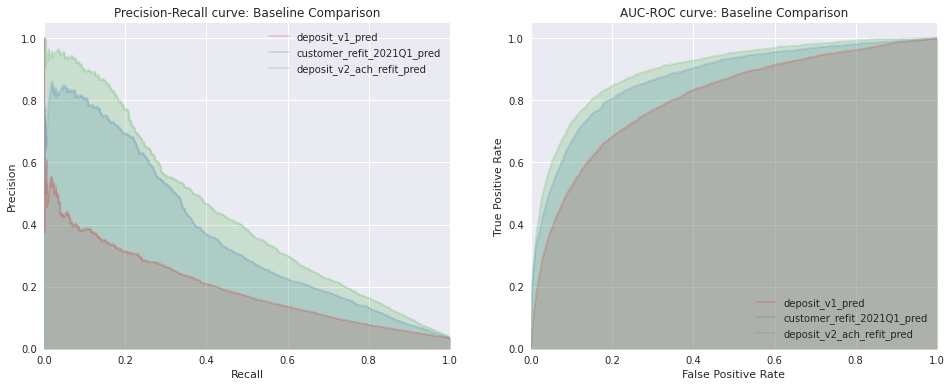

========= month: 3 =========


,auc,ap,ks
deposit_v1_pred,81.88,23.27,50.09
customer_refit_2021Q1_pred,87.29,38.34,60.35
deposit_v2_ach_refit_pred,89.50,43.68,64.47


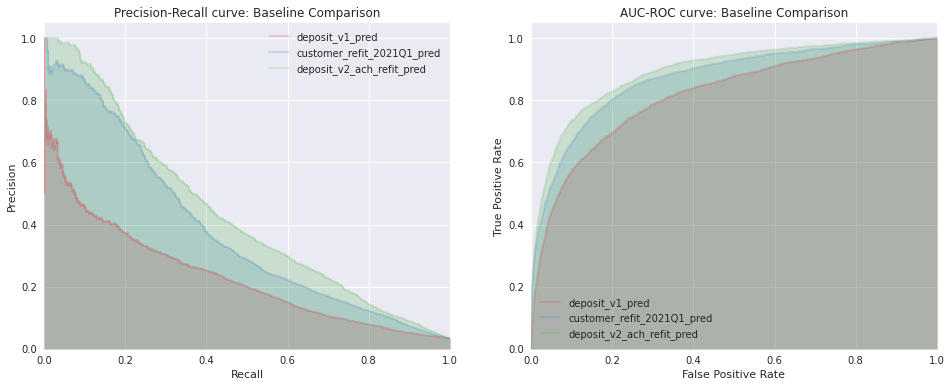

========= month: 4 =========


,auc,ap,ks
deposit_v1_pred,81.58,21.92,49.56
customer_refit_2021Q1_pred,87.16,38.43,60.74
deposit_v2_ach_refit_pred,88.92,44.43,64.28


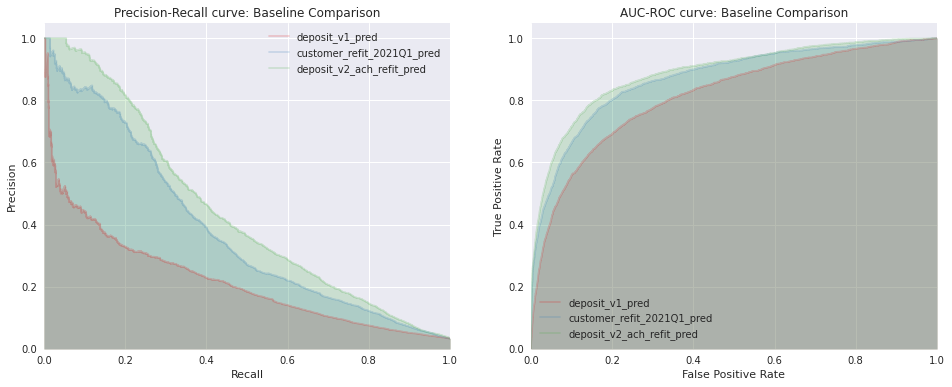

========= month: 5 =========


,auc,ap,ks
deposit_v1_pred,80.48,25.19,48.21
customer_refit_2021Q1_pred,86.08,38.90,57.96
deposit_v2_ach_refit_pred,88.86,46.17,64.20


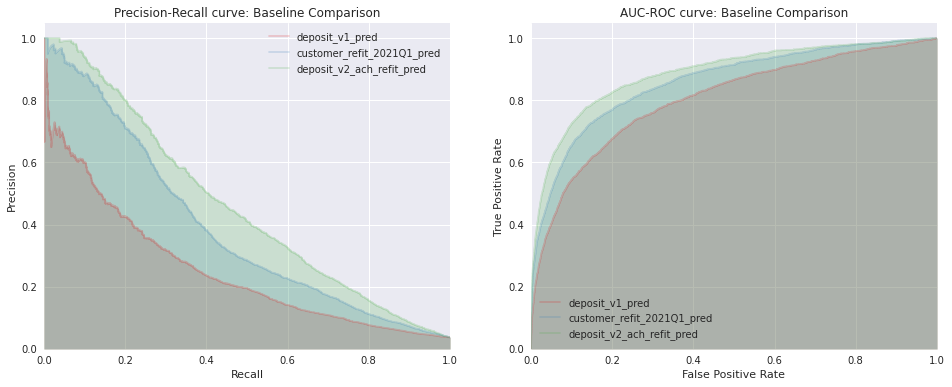

In [12]:
for m in test_df.transaction_datetime.dt.month.unique():
    print(f"========= month: {m} =========")
    test_df_ = test_df[test_df.transaction_datetime.dt.month == m]
    preds = [(test_df_[col], col) for col in pred_cols]
    targets = test_df_[target_col]

    metrics = get_pred_reports(test_df_, target_col, pred_cols)
    display(metrics)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    cmap = plt.get_cmap('Set1')
    colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

    title = 'Precision-Recall curve: Baseline Comparison'
    plot_pr_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[0], fig=fig) 

    title = 'AUC-ROC curve: Baseline Comparison'
    plot_auc_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[1], fig=fig)
    plt.show()

### Study Feb dip behavior
---

### Segmented by Activeness
---

We have strong divergence between PR on active and inactive accounts. Need to find out what has caused the issue. 

Also, our MC Constraint is determined by WOE transform, but it considers number of transactions per day to be positively proportional to the likelihood of ACH returns. Should we consider this behavior to be realistic? or enforce it to penalize in-active accounts?


In [13]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)

df_active = test_df[test_df.is_active]
df_inactive = test_df[~test_df.is_active]

,auc,ap,ks
deposit_v1_pred,81.08,23.58,48.75
customer_refit_2021Q1_pred,86.80,32.28,60.09
deposit_v2_ach_refit_pred,88.22,34.63,62.29


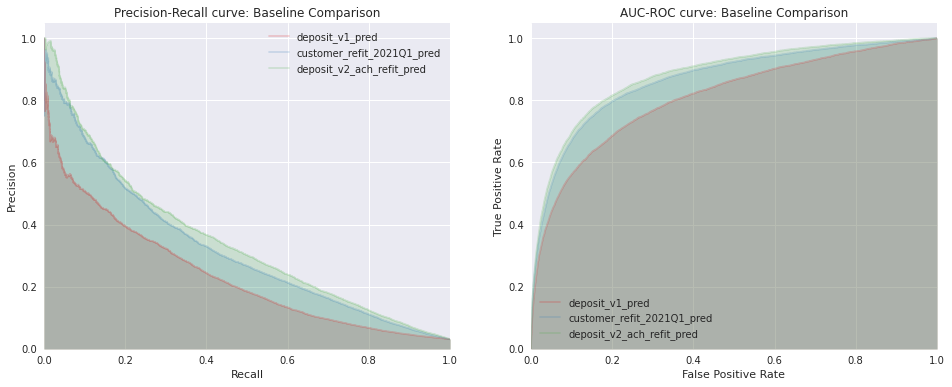

,auc,ap,ks
deposit_v1_pred,76.96,18.43,41.34
customer_refit_2021Q1_pred,92.06,66.86,68.23
deposit_v2_ach_refit_pred,93.61,74.62,74.06


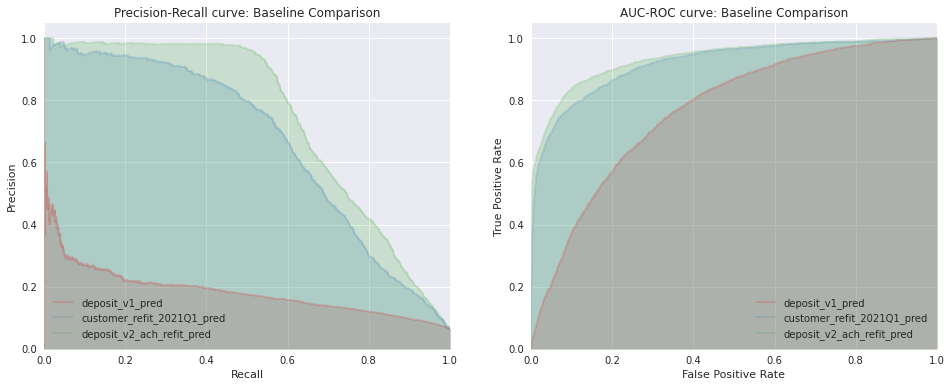

In [14]:
for test_df_ in [df_active, df_inactive]:
    print(f"================================")
    preds = [(test_df_[col], col) for col in pred_cols]
    targets = test_df_[target_col]

    metrics = get_pred_reports(test_df_, target_col, pred_cols)
    display(metrics)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    cmap = plt.get_cmap('Set1')
    colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

    title = 'Precision-Recall curve: Baseline Comparison'
    plot_pr_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[0], fig=fig) 

    title = 'AUC-ROC curve: Baseline Comparison'
    plot_auc_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[1], fig=fig)
    plt.show()

In [15]:
# accounts that got mis-classified
df_ = test_df[test_df.is_active & test_df.score > 99 & ~test_df.target_60d]
df_.shape, df_.business_account_number.nunique()

((12290, 265), 5679)

In [16]:
df_.index

Int64Index([   338,    365,    366,    367,    553,    554,    555,    556,
               557,   1070,
            ...
            256720, 256744, 256840, 256888, 256889, 256916, 257098, 257129,
            257130, 257164],
           dtype='int64', length=12290)

The performance on the ability to capture inactive accounts seems to be too good. Let's find out why?

In [17]:
# How to take a look at them? SHAP?
with open("../../artifacts/ach-mc-refit/governance/model.pkl", "rb") as f:
    model = pkl.load(f)

In [18]:
%%time 
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
X = test_df[model.feature_name_]
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.initjs()

CPU times: user 3min 36s, sys: 0 ns, total: 3min 36s
Wall time: 2.79 s


In [19]:
shap_values.shape

(257328, 23, 2)

TypeError: only integer scalar arrays can be converted to a scalar index

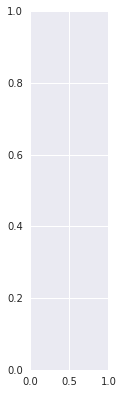

In [20]:
shap.summary_plot(shap_values, X)

In [ ]:
from src.governance import get_shap_dependence, get_feature_by_importance
from src.preprocessing import utils as pu

In [ ]:
def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None,
                        lquantile=0.01, rquantile=0.99, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    import math
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(rquantile)
        llim = df[feature].quantile(lquantile) #- ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

In [ ]:
shap.initjs()

feature_by_imp = get_feature_by_importance(model)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_df[model.feature_name_])

fig = get_shap_dependence(test_df[model.feature_name_], 
                          shap_values[1], feature_by_imp, 
                          interaction_index=None, 
                          lquantile=0.02, rquantile=0.98)

What questions do I want to have answered? Why is the performance on the inactive accounts to be so good?
---

How to find out why: look at multiple accounts and look at how the model ended up in its decision.

In [ ]:
df_ = test_df[test_df.is_active & test_df.score > 99 & ~test_df.target_60d]

feature_by_imp = get_feature_by_importance(model)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_[model.feature_name_])

fig = get_shap_dependence(df_[model.feature_name_], 
                          shap_values[1], feature_by_imp, 
                          interaction_index=None)